# Auto Sales Comparison

## This project seeks to find the answers to these questions:
- What are average car sales prices for each car type?
- What are overall total sales for each car type?
- Is there a correlation between number of cylinders and the condition of car?
- Is there a correlation between odometer reading, and days on market?
- What are the average prices, by color?
- What are average car prices, by year?

## I will also plot some of these answer on to interactive graphs.

<h2 style="color:red;">Import libraries</h2>

In [71]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import streamlit as st

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import altair as alt

import numpy as np

from scipy import stats

from IPython.display import Image

In [72]:
Image(url='../cars_balloons.jpeg', width=300, height=300) 

In [73]:
autos = pd.read_csv("../vehicles_us.csv")

<h2 style="color:red;">Inspect the Data</h2>

In [75]:
display(autos.head(5))

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


#### Initial thoughts on the dataset:
- A few of the column names will need to be renamed to shorter names.
- A few of the column data types will need to be changed, from float to int.

In [77]:
autos.shape

(51525, 13)

#### There are 51,525 rows, and 13 columns.

In [79]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


#### These columns have missing data:
- model_year
- cylinders
- odometer
- paint_color
- is_4wd

#### These columns do not need decimals. Data types will need to be changed on these columns:
- model_year
- cylinders
- odometer
- is_4wd

In [82]:
autos.describe()

,price,model_year,cylinders,odometer,is_4wd,days_listed
count,51525.000000,47906.000000,46265.000000,43633.000000,25572.0,51525.00000
mean,12132.464920,2009.750470,6.125235,115553.461738,1.0,39.55476
std,10040.803015,6.282065,1.660360,65094.611341,0.0,28.20427
min,1.000000,1908.000000,3.000000,0.000000,1.0,0.00000
25%,5000.000000,2006.000000,4.000000,70000.000000,1.0,19.00000
50%,9000.000000,2011.000000,6.000000,113000.000000,1.0,33.00000
75%,16839.000000,2014.000000,8.000000,155000.000000,1.0,53.00000
max,375000.000000,2019.000000,12.000000,990000.000000,1.0,271.00000


<b> A quick glance shows:</b>
<br>
- The oldest car that has sold, from this dataset, was over 100 years old, from the year 1908.
- The average sale price is \$12,132.  
- The highest sales price is \$375,000.
- The most cylinders on any of these cars is 12. The least is 3.
- The average odometer reading is 115,553.
- The average days listed is 40 days.

In [84]:
Image(url='../car_wash.jpeg', width=300, height=300) 

<h2 style="color:red;">Clean the data</h2>

### Rename column names

In [87]:
autos.rename(columns={'model_year': 'year', 'paint_color': 'color', 'cylinders': 'cyl', 'days_listed': 'DOM'}, inplace=True)
display(autos.head(3))

,price,year,model,condition,cyl,fuel,odometer,transmission,type,color,is_4wd,date_posted,DOM
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79


### Get rid of Nan values.

In [89]:
# Fill NaN values with 0
autos['year'] = autos['year'].fillna(0)

<div class="alert alert-info"><font color='hotpink'>
#Commenting out this code, as I will try a different method.
<br>
#autos['cyl'] = autos['cyl'].fillna(0)
</div></font color>

### Imputate data

In [92]:
# Group by 'model' and 'year' and transform to calculate medians. Each unique combination of model and year is considered independently.
autos['cyl'] = autos.groupby(['model', 'year'])['cyl'].transform(lambda x: x.fillna(x.median()))

In [93]:
# Calculate the average of the 'odometer' column while ignoring NaN values
mean_odometer = autos['odometer'].mean()

# Fill NaN values with the calculated average
autos['odometer'] = autos['odometer'].fillna(mean_odometer)

In [94]:
# Fill Nan with "unknown"
autos['color'] = autos['color'].fillna('unknown')

In [95]:
autos['is_4wd'] = autos['is_4wd'].fillna(pd.Series(np.random.choice([0.0, 1.0], size=len(autos['is_4wd']))))

### Get rid of '0' values

In [97]:
# Replace 0 with None or NaN
autos['year'] = autos['year'].replace(0, pd.NA)

### Change data types

In [99]:
# Change the data type to a nullable integer type. Supports missing data.
autos['year'] = autos['year'].astype('Int64')

# Change the data type from float to int
autos['odometer'] = autos['odometer'].astype(int)

In [100]:
# Get rid of decimals in cyl column
autos['cyl'] = autos['cyl'].astype(int)
print(autos.cyl.head(5))

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# Convert 'condition' and 'color' to categorical
autos['condition'] = autos['condition'].astype('category')
autos['color'] = autos['color'].astype('category')
#autos['cyl'] = autos['cyl'].astype('category')

In [ ]:
#Change data type of date_posted column to type datetime
autos['date_posted'] = pd.to_datetime(autos['date_posted'])

#Format the date_posted column to mm-dd-yyyy
autos['date_posted'] = autos['date_posted'].dt.strftime('%m-%d-%Y')

In [ ]:
#Convert to type boolean
autos['is_4wd'] = autos['is_4wd'].astype(bool)
#autos['is_4wd'] = autos['is_4wd'].map({0.0: 0, 1.0: 1})

In [ ]:
display(autos.head(3))

In [ ]:
autos.info()

In [ ]:
display(autos.tail(13))

In [ ]:
autos['year'].min()

In [ ]:
autos['year'].max()

In [ ]:
autos['year'].value_counts()

In [ ]:
result = (3619 / 51525) * 100
rounded_result = round(result, 2)
print(str(rounded_result) + '% of the values in the "years" column have missing data')

In [ ]:
autos['condition'].value_counts()

In [ ]:
autos['transmission'].value_counts()

In [ ]:
autos['type'].value_counts()

In [ ]:
autos['color'].value_counts()

In [ ]:
Image(url='../car_wax.jpeg', width=300, height=300) 

### Remove outliers

#### Remove 'price' outliers

In [ ]:
autos.price.describe()

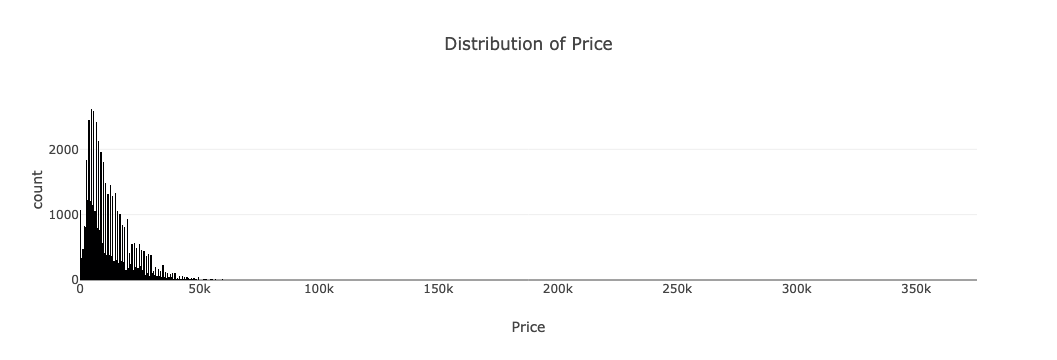

In [119]:
# Create a histogram chart with Plotly Express
fig = px.histogram(autos, x='price', title='Distribution of Price', labels={'price': 'Price', 'count': 'Frequency'})
# Show the chart
fig.show()

In [121]:
#### The distribution of 'price' is right skewed. The outliers need to be removed.

<div class="alert alert-info"><font color='hotpink'>
Commenting out this section, as I will be using a manual method of removing outliers.
</div></font>

In [131]:
# Calculate the first quartile (Q1)
#price_Q1 = autos['price'].quantile(0.25)

# Calculate the third quartile (Q3)
#price_Q3 = autos['price'].quantile(0.75)

# Calculate the IQR
#price_IQR = price_Q3 - price_Q1

#print("price 1st quartile: " + str(price_Q1))
#print("price 3rd quartile: " + str(price_Q3))
#print("price IQR: " + str(price_IQR))

<div class="alert alert-info"><font color='hotpink'>
Trying this manual method of removing outliers instead. 
</div></font>

In [136]:
# Set pandas to show all rows, so value_counts does not get cut off.
pd.set_option('display.max_rows', None)

# Get and print the value counts for the 'price' column
price_counts = autos['price'].value_counts()

price_counts_reset = price_counts.reset_index()

price_counts_reset.columns = ['price', 'count']

sorted_price_counts = price_counts_reset.sort_values(by='price')

print(sorted_price_counts)

       price  count
0          1    798
2212       3      1
2174       5      1
1977       6      1
2259       9      1
2090      10      1
2014      11      1
1406      12      3
1202      15      3
2599      20      1
2743      24      1
1644      25      2
2720      28      1
3272      32      1
1564      35      2
2958      36      1
1294      39      3
3200      65      1
298       69     34
1594      80      2
1068      85      4
3101     105      1
2651     111      1
1945     147      1
1403     155      3
3115     169      1
2211     171      1
1387     176      3
2425     179      1
1601     180      2
1252     185      3
2112     187      1
1165     188      4
2436     190      1
2435     195      1
1372     196      3
1189     197      3
1208     198      3
505      199     15
929      200      5
1186     204      3
1423     206      3
1440     211      3
1740     215      2
1234     222      3
1173     228      4
1399     233      3
1170     237      4
1395     243      3


#### On closer inspection of the 'price' outliers, I am surprised to see so many cars that sold for one dollar.  This is creating a lot of outliers. 

In [142]:
# Create variables to remove outliers, in 'price', lower than 199, and higher than 100000.
lower_threshold = 199
upper_threshold = 100000

In [144]:
# Filter outliers. Create new dataframe.
filtered_autos_price = autos[(autos['price'] >= lower_threshold) & (autos['price'] <= upper_threshold)]

In [146]:
#Create histogram without outliers.

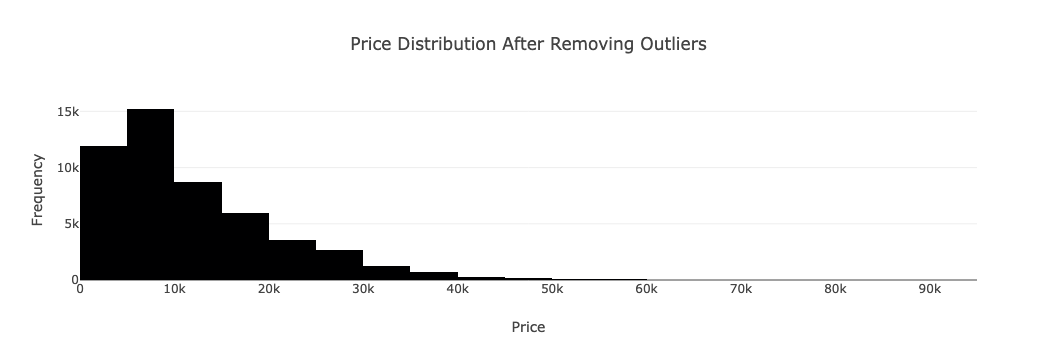

In [148]:
# 'price' column after removing outliers, using plotly
fig_hist = px.histogram(filtered_autos_price, x='price', nbins=40, title='Price Distribution After Removing Outliers')

fig_hist.update_layout(
    xaxis_title='Price',
    yaxis_title='Frequency'
)

fig_hist.show()

<div class="alert alert-info"><font color='hotpink'>The histogram is still right skewed, even after removing outliers for 'price' 
</div></font>

In [ ]:
# Define the lower bound (anything below this value is considered an outlier)
price_lower_bound = price_Q1 - 1.5 * price_IQR

# Define the upper bound (anything above this value is considered an outlier)
price_upper_bound = price_Q3 + 1.5 * price_IQR

# Negative number confirms that there was an extreme outlier in the price column
print(price_lower_bound)
print(price_upper_bound)

In [ ]:
#'price' column now has a new range of data that falls between the lower bound and the upper bound, as created above.
autos['price'] = autos.loc[(autos['price'] >= price_lower_bound) & (autos['price'] <= price_upper_bound), 'price']

#### After removing 'price' outlier, max price has gone from \$ 370,000 to 34,595.

### Remove 'odometer' outliers

In [ ]:
# Create a histogram chart with Plotly Express
fig = px.histogram(autos, x='odometer', title='Distribution of Odometer readings', labels={'Odometer': 'odometer', 'count': 'Frequency'})
# Show the chart
fig.show()

#### The distribution of 'odometer' is right skewed. The outliers need to be removed.

In [ ]:
autos.odometer.describe()

#### Highest odometer reading is 990,000 miles. That is unrealistic.

In [ ]:
# Calculate the first quartile (Q1)
odo_Q1 = autos['odometer'].quantile(0.25)

# Calculate the third quartile (Q3)
odo_Q3 = autos['odometer'].quantile(0.75)

# Calculate the IQR
odo_IQR = odo_Q3 - odo_Q1

print("odometer 1st quartile: " + str(odo_Q1))
print("odometer 3rd quartile: " + str(odo_Q3))
print("odometer IQR: " + str(odo_IQR))

In [ ]:
# Define the lower bound (anything below this value is considered an outlier)
odo_lower_bound = odo_Q1 - 1.5 * odo_IQR

# Define the upper bound (anything above this value is considered an outlier)
odo_upper_bound = odo_Q3 + 1.5 * odo_IQR

# Negative number confirms that there was an extreme outlier in the 'odometer' column
print(odo_lower_bound)
print(odo_upper_bound)

In [ ]:
#change 'odometer' to only contain the range between upper bound and lower bound.
autos['odometer'] = autos.loc[(autos['odometer'] >= odo_lower_bound) & (autos['odometer'] <= odo_upper_bound), 'odometer']

In [ ]:
autos.odometer.describe()

#### After removing outliers, max odometer reading has gone from 990,000 to 247,548.

In [ ]:
# Create a histogram chart with Plotly Express
fig = px.histogram(autos, x='odometer', title='Distribution of Odometer readings', labels={'Odometer': 'odometer', 'count': 'Frequency'})
# Show the chart
fig.show()

In [ ]:
Image(url='../car_clean.jpeg', width=300, height=300) 

### The dataset is clean now.
- 4 columns have been renamed to shorter names, so that it is no longer necessary to scroll to see all the columns. "transmission" is a long column name, however, the values inside that column are also long, so that column name was not changed.
<br>
<br>
- There is no missing data now. I used fillna to change all Nan values to 0 for the 'cyl' column. Because 7% of the values, in the 'year' column, are missing values, I did not want to drop 3619 rows. I chose to use pd.na to change 0 to NA, in the 'year' column, because I did not want to delete rows. The NA will just be ignored when my graph grabs data for 'year'.  For the odometer column, I took the average of all the odometer readings, and used fillna to change Nan values to the average odometer reading. For Nan values in the color column, I changed those to "unknown". For the 'is_4wd' column, I used np.random to randomly change some Nan to 0.0, and some to 1.0, as this column is meant to be boolean. 
<br>
<br>
- Data types are appropriate now. I changed 'year', and 'odometer' to type int, because there is no reason to have decimals with those values. I used pd.to_datetime and dt.strftime to change the date_posted column to type datetime, then change the output so that it prints as mm-dd-yyyy. I used astype, to change the is_4wd column, from float to type bool, and now there are just 0 or 1 in that column. I changed the data type of the 'condition' and 'color' columns to type category, to make it easier to plot that info on a graph.
<br>
<br>
- I removed outliers in the 'price' column because my graphs appeared pretty empty, trying to accomodate one sale price of $375,000. I found the 1st quartile, and the 3rd quartile.  Then I found the lower bound, and the upper bound, and made sure that the new 'price' column only contained data within those ranges.  
<br>
<br>
- I also removed outliers in the 'odometer' column, using that same method.

<h2 style="color:red;">Explore answers to the questions</h2>

### What are average car sales prices for each car type?

#### Create Scatter plot

In [ ]:
# Calculate average price by car type
avg_price_by_type = autos.groupby('type')['price'].mean().round(2)
avg_price_by_type_sorted = avg_price_by_type.sort_values(ascending=False).reset_index()

# Create scatter plot using Plotly
fig_scatter = px.scatter(
    avg_price_by_type_sorted,
    x='type',
    y='price',
    title='Average Sales Prices by Car Type',
    labels={'type': 'Car Type', 'price': 'Average Price ($)'},
    color='type',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    size='price',  # Optional: makes larger points for higher prices
    hover_name='type'  # add hover info
)

# Customize appearance
fig_scatter.update_layout(
    title={'x': 0.5, 'font': {'size': 24}},
        xaxis=dict(
        title=dict(
            text='Car Type',
            font={'size': 18}
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
        yaxis=dict(
        title=dict(
            text='Average Price ($)',
            font={'size': 18}
        ),
        showgrid=True,
        gridwidth=1,
        gridcolor='LightGray'
    ),
    height=600,
    legend_title_text='Car Type',
    font=dict(size=18)
)

# Show the plot
fig_scatter.show()

#### Review of average prices:
- Buses sell for the higest prices. Hatchbacks sell for the lowest prices.
<br>
- From info gathered earlier, we know that the average car sales price is $12,132. Therefore, SUV's, vans, wagons, mini-vans, sedans, and hatchbacks sell for below average prices.

### What are overall total sales for each car type?

In [ ]:
# Group by 'type' and sum 'price' with observed=False (retain current behavior)
total_sales = autos.groupby('type', observed=False)['price'].sum().reset_index()
# Print the result
print(total_sales)

#### Create Bar Chart

In [ ]:
# Create bar chart for total sales by car type using Plotly
fig_bar = px.bar(
    total_sales,
    x='type',
    y='price',
    title='Total Sales by Car Type',
    labels={'type': 'Car Type', 'price': 'Total Sales'},
    color='type',
    color_discrete_sequence=px.colors.qualitative.Plotly  # Set color palette
)

# Customize layout and set the height of the chart
fig_bar.update_layout(
    xaxis_title={'text': 'Car Type', 'font': {'size': 18}},
    yaxis_title={'text': 'Total Sales', 'font': {'size': 18}},
    title={
        'text': 'Total Sales by Car Type',
        'x': 0.5,
        'font': {'size': 24}
    },
    height=800,
    legend=dict(
        title='Car Type',
        font=dict(size=16),
        x=0.5,
        xanchor='center',
        y=1,
        yanchor='top',
        bgcolor="white",  # Background color for the legend
        bordercolor="black",  # Border color for the legend
        borderwidth=2,  # Border width in pixels
    )
)

# Show the plot
fig_bar.show()

In [ ]:
# Create a bar chart
# Enable the JSON data transformer for large datasets
from IPython.display import display
alt.data_transformers.enable('json')

# Create a bar chart for total sales by car type
chart = alt.Chart(total_sales).mark_bar().encode(
    x=alt.X('type:O', axis=alt.Axis(labelAngle=45), title='Car Type'),
    y=alt.Y('price:Q', title='Total Sales'),
    color=alt.Color('type:N', legend=None)
).properties(
    title='Total Sales by Car Type'
)

# Save the chart as an HTML file
chart.save('chart.html')
from IPython.display import IFrame
IFrame('chart.html', width=800, height=600)

####  This bar graph is sorted by vehicles that sell for the highest amount ( on the left ), to lowest amount ( on the right ).
- Although buses sell for a higher average amount, than any other vehicle, there were only 24 buses in this dataset. So the bar is the shortest bar on the graph.
- Trucks bring in the most revenue of all vehicles. Their average sale price is \$16,734.89, and there were 12,353 trucks in the dataset.
- The average sale price for hatchbacks is \$6,869 and there were 1047 hatchbacks in this dataset.
- There were 12,405 SUVs in this dataset, which is more than any other vehicle. The average price for SUVs is $11,149.40
- Trucks and SUVs bring in the most revenue.                                                                                  

### Is there a correlation between number of cylinders and the condition of car?

In [ ]:
# Calculate the average price for each type and sort by it in descending order with observed=True
avg_price_by_type = autos.groupby('type', observed=True)['price'].mean().sort_values(ascending=False)
# Convert Series to list
unique_categories = avg_price_by_type.index.tolist()

print(round(avg_price_by_type),2)  # Displays the average price sorted by car type
print(unique_categories)  # Displays the car types sorted by average price

#### Create Scatter plot

In [ ]:
# Set the order of the 'type' column based on the average price sorting
autos['type'] = pd.Categorical(autos['type'], categories=unique_categories, ordered=True)

# Ensure the DataFrame is sorted by the type order we created (for consistency)
autos_sorted = autos.sort_values(by=['type'])

# Define condition order and convert to categorical
condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
autos['condition'] = pd.Categorical(autos['condition'], categories=condition_order, ordered=True)

# Manually set the order of unique cyl values for tick labels
cyl_order = [0, 3, 4, 5, 6, 8, 10, 12]

In [ ]:
# Define a custom color palette
color_palette = px.colors.qualitative.Plotly

# Create scatter plot using Plotly
fig_scatter = px.scatter(
    autos,
    x='condition',
    y='cyl',
    color='type',
    title='Condition of Car vs Number of Cylinders',
    labels={'condition': 'Condition', 'cyl': 'Number of Cylinders'},
    color_discrete_sequence=color_palette,
    hover_name='type',
    category_orders={'condition': condition_order}
)
# Customize layout and set the height of the chart
fig_scatter.update_layout(
    xaxis_title={'text': 'Condition', 'font': {'size': 18}},
    yaxis_title={'text': 'Number of Cylinders', 'font': {'size': 18}},
    yaxis=dict(
        tickmode='array',
        tickvals=cyl_order,
        ticktext=[str(val) for val in cyl_order]
    ),
    title={
        'text': 'Number of Cylinders vs Condition of Car, by Type',
        'x': 0.5,
        'font': {'size': 24}
    },
    height=800,
    
    legend=dict(
        font=dict(size=16),
        title=dict(
            font=dict(size=18),
            text='    type    '  # Center the legend title text
        ),
        itemsizing='constant',
        x=0.88,
        y=1,
        bgcolor="white",  # Background color for the legend
        bordercolor="black",  # Border color for the legend
        borderwidth=2  # Border width in pixels
    )
)

# Update marker size
fig_scatter.update_traces(marker=dict(size=15))

# Show the plot
fig_scatter.show()

#### Create Box plot

In [ ]:
#Create box plot, using plotly
fig = px.box(autos, x='condition', y='cyl', title='Distribution of Cylinders by Condition')

# Customize the layout to change the size of the text and make the plot taller
fig.update_layout(
    xaxis=dict(
        categoryorder='array',
        categoryarray=condition_order
    ),
    title={'text': ' Number of Cylinders vs Condition of Car', 'font': {'size': 24}},
    xaxis_title={'text': 'Condition', 'font': {'size': 18}},
    yaxis_title={'text': 'Number of Cylinders', 'font': {'size': 18}},
    height=800  # Specify the height of the chart in pixels
)


# Display the plot
fig.show()

### There is a slight correlation between number of cylinders, and condition of car. 
<br>
- Cars with 12 cyclinders only appear in the 'excellent' category; there are no cars, with 12 cylinders in any other category.
<br>
<br>
- Cars with 10, or 12 cylinders do not appear in the 'salvage' category, which is the lowest value of a car's condition.

In [ ]:
# Group by 'cyl' and 'condition', and count the occurrences
# Specify observed=False to retain current behavior and silence the warning
cyl_condition_counts = autos.groupby(['cyl', 'condition'], observed=False).size().reset_index(name='count')

In [ ]:
# Calculate the total number of autos per cylinder
total_per_cyl = autos.groupby('cyl', observed=False).size().reset_index(name='total')

In [ ]:
# Merge the counts with the totals
cyl_condition_counts = cyl_condition_counts.merge(total_per_cyl, on='cyl')

In [ ]:
# Calculate the percentage
cyl_condition_counts['percentage'] = (cyl_condition_counts['count'] / cyl_condition_counts['total']) * 100
# Display the results
print(cyl_condition_counts)

In [ ]:
total_cars = len(autos)

In [ ]:
# Count the number of salvage cars
salvage_cars = autos['condition'].value_counts().get('salvage', 0)
print(salvage_cars)

In [ ]:
# Calculate the percentage of salvage cars
percentage_salvage = (salvage_cars / total_cars) * 100

In [ ]:
print(f"Total number of cars: {total_cars}")
print(f"Count of salvage cars: {salvage_cars}")

# Print percentage rounded to two decimal places
print(f"Percentage of cars that are in 'salvage' condition: {percentage_salvage:.2f}%")

In [ ]:
# Count the number of excellent cars
excellent_cars = autos['condition'].value_counts().get('excellent', 0)
print(excellent_cars)

In [ ]:
# Calculate the percentage of excellent cars
percentage_excellent = (excellent_cars / total_cars) * 100

In [ ]:
print(f"Total number of cars: {total_cars}")
print(f"Count of excellent cars: {excellent_cars}")

# Print percentage rounded to two decimal places
print(f"Percentage of excellent cars: {percentage_excellent:.2f}%")

### Looking at the output of percentages of cars, relating to each condition type:
<br>
<b>The percentage of total salvage cars is less than 1%.</b>
<br>
<br>
- There is a disproportionate number of salvage cars that have 4 cylinders, with the salvage condition making up 0.35%. Since the total number of salvage cars is only 0.22%, this is slightly higher than expected.
<br>
<br>
- There is an even higher disproportion of salvage cars that have 3 cylinders...  2.9%. And since the total number of salvage cars is only 0.22%, this is over 10 times higher than expected.
<br>
<br>
<b> The percentage of total excellent cars is 48%.</b>
<br>
<br>
- There is a disproportionate number of excellent cars that have 12 cylinders, with 100% of cars with 12 cylinders falling in the excellent condition category. 
<br>
<br>
<b>So, there is some proof to show that the lesser amount of cylinders a car has, the worse condition it is in.</b>
<br>
<b>And, there is some proof to show that the more cylinders that a car has, the better condition it is in.</b>

### Is there a correlation between odometer reading, and days on market?

#### Create Histogram

In [ ]:
# Create a 2D histogram object for odometer vs DOM
fig = go.Figure(
    data=go.Histogram2d(
        x=autos['odometer'], 
        y=autos['DOM'], 
        colorscale='Blues'
    )
)

# Customize layout and add labels
fig.update_layout(
    title={'text': 'Histogram of Odometer vs Days on Market (DOM)', 'x': 0.5, 'font': {'size': 24}},
    xaxis=dict(
        title='Odometer (miles)',
        titlefont=dict(size=20),  # Set x-axis title font size
        range=[0, 200000] 
    ),
    yaxis=dict(
        title='Days on Market (DOM)',
        titlefont=dict(size=20)  # Set y-axis title font size
    ),
    height=800
)

#Show the histogram
fig.show()
    
    

In [ ]:
autos.DOM.describe()

### What are the average prices, by color?

In [ ]:
# calculate the average price and round to 2 decimal places
avg_price_by_color = autos.groupby('color', observed=False)['price'].mean().round(2).reset_index()

# Print the aggregated data to verify the average values
print(avg_price_by_color)

In [ ]:
# Define a direct color mapping for each category
color_mapping = {
    'white': 'white',
    'unknown': 'pink',
    'black': 'black',
    'silver': 'silver',
    'grey': 'grey',
    'blue': 'blue',
    'red': 'red',
    'green': 'green',
    'brown': 'brown',
    'custom': 'limegreen',
    'yellow': 'yellow',
    'orange': 'orange',
    'purple': 'purple'
}
fig_bar = px.bar(
    avg_price_by_color, 
    x='color', 
    y='price', 
    title='Average Price by Color',
    color='color', 
    color_discrete_map=color_mapping
)

# Convert from px.bar to go.Figure to add customizations
fig = go.Figure(fig_bar)

# Update each bar trace to add a black border
for trace in fig.data:
    trace.update(marker_line_color='black', marker_line_width=1.5)
    
# Find the max average price value for y-axis settings
max_price = avg_price_by_color['price'].max()

# Customize the layout
fig.update_layout(
    title={'text': 'Average Prices by Color', 'x': 0.5, 'font': {'size': 24}},
    xaxis=dict(
        title='Color',
        titlefont=dict(size=18)  # Set x-axis title font size
    ),
    yaxis=dict(
        title='Average Price',
        titlefont=dict(size=18),  # Set y-axis title font size
        tickvals=[i for i in range(0, int(max_price) + 5000, 5000)],  # Adjust ticks as needed
        range=[0, int(max_price) + 1000]  # Adjust range as needed
    ),
    height=800
)

# Show the bar plot
fig.show()

#### Yellow and orange cars sell for the highest price. Purple and green cars sell for the lowest price, with purple selling for less than half the price of yellow and orange cars.

### What are average car prices, by year?

In [ ]:
autos.describe()

#### Average car price is \$34,595.

In [ ]:
autos['year'].max()

In [ ]:
#Group by 'year' and calculate average price
avg_price_by_year = autos.groupby('year')['price'].mean().reset_index()

# Create a bar chart with a color sequence
fig = px.bar(
    avg_price_by_year,
    x='year',
    y='price',
    title='Average Car Prices, Since 1960',
    labels={'year': 'Year', 'price': 'Average Price ($)'},
    color='year',  # Use year for coloring (if necessary)
    color_continuous_scale=px.colors.sequential.Viridis  # Example color scale
)

# Define the range and tick marks
start_year = 1960
end_year = 2019
tick_vals = list(range(start_year, end_year + 1, 5))  # Generate a list from 1960 to 2019 with a step of 5
tick_texts = [str(year) for year in tick_vals]  # Create tick labels as strings
# Update layout
fig.update_layout(
    xaxis=dict(
        title='Year',
        titlefont=dict(size=18),
        range=[start_year, end_year],  # x-axis range
        tickvals=tick_vals,  # Sets the locations of ticks
        ticktext=tick_texts  # Sets the labels of the ticks
    ),
    yaxis=dict(title='Average Price ($)', titlefont=dict(size=18)),
    title={'x': 0.5, 'font': {'size': 24}},
    height=600
)

# Show the bar chart
fig.show()

In [ ]:
avg_price_by_year.min()

<h2 style="color:red;">Conclusion</h2>

## This dataset represented auto sales, for the years 1908-2019. I studied these aspects of the data:
<br>
<br>
- price	
<br>
- year	
<br>	
- condition of car
<br>
- number of cylinders	
<br>	
- odometer reading
<br>	
- type of car  
<br>
- color	
<br>		
- days on market
<br>
<br>
<h2>Here are the answers to the questions that I seeked to find:</h2>
<br>
<br>
 
<b>What are average car sales prices for each car type?</b>
<br>
- The highest price on vehicles, in this dataset, results from bus sales, with the average sale price of busses be \$17,136.
- Trucks sell for the second highest price, at an average of \$14,821
<br>
<br>

<b>What are overall total sales for each car type?</b>
<br>
<br>
           SUV &nbsp;&nbsp;&nbsp;   \$125,396,205
<br>
           bus &nbsp;&nbsp;&nbsp;      \$411,256
<br>
   convertible &nbsp;&nbsp;&nbsp;     \$5,292,414
<br>
         coupe &nbsp;&nbsp;&nbsp;    \$29,536,818
<br>
     hatchback &nbsp;&nbsp;&nbsp;     \$7,156,335
<br>
      mini-van &nbsp;&nbsp;&nbsp;     \$9,261,424
<br>
       offroad &nbsp;&nbsp;&nbsp;     \$2,714,601
<br>
         other &nbsp;&nbsp;&nbsp;     \$2,647,813
<br>
        pickup &nbsp;&nbsp;&nbsp;    \$96,745,712
<br>
         sedan &nbsp;&nbsp;&nbsp;    \$84,328,720
<br>
        truck &nbsp;&nbsp;&nbsp;   \$171,180,709
<br>
          van &nbsp;&nbsp;&nbsp;     \$5,167,314
<br>
        wagon &nbsp;&nbsp;&nbsp;    \$13,596,040
<br>
<br>

- SUVs and Trucks have generated the highest amount in total sales.
<br>
<br>

<b>Is there a correlation between number of cylinders and the condition of car?</b>
<br>
- Cars with 12 cyclinders only appear in the 'excellent' category; there are no cars, with 12 cylinders in any other category. 
- Cars with 10, or 12 cylinders do not appear in the 'salvage' category, which is the lowest value of a car's condition.
<br>
<br>
    
<b>Is there a correlation between odometer reading, and days on market?</b>
<br>
<br>
- The lower the odometer reading, the quicker the car sells. 
- The majority of the cars that sold had an odometer reading of 110,000-120,000  miles, and were on the market 15-19 days.
<br>
<br>
    
<b>What are the average prices, by color?</b>
<br>
- Yellow cars sold for the highest average prices, with orange coming in second place. 
- Purple cars sold for the lowest average prices.
<br>
<br>
           yellow &nbsp;&nbsp;&nbsp;   \$14,964 
<br>
           orange &nbsp;&nbsp;&nbsp;   \$13,603 
<br>
           purple &nbsp;&nbsp;&nbsp;   \$6,518
<br>
<br>
           black &nbsp;&nbsp;&nbsp;   \$12,310
<br>
           blue &nbsp;&nbsp;&nbsp;   \$9,617
<br>
           brown &nbsp;&nbsp;&nbsp;   \$9,668
<br> 
           custom &nbsp;&nbsp;&nbsp;   \$9,588
<br>
           green &nbsp;&nbsp;&nbsp;   \$8,178 
<br>
           grey &nbsp;&nbsp;&nbsp;   \$10,446
<br>
           red &nbsp;&nbsp;&nbsp;   \$10,597 
<br> 
           silver &nbsp;&nbsp;&nbsp;   \$10,069
<br> 
           unknown &nbsp;&nbsp;&nbsp;   \$11,215
<br>
           white &nbsp;&nbsp;&nbsp;   \$12,621  
<br>


<br>
<br>

<b>What are average car prices, by year?</b>
<br>
<br>
- The newest cars in this dataset are year 2019. 
- The average 2019 prices are about the same as the average sales price of 1965 cars. 
- The oldest year in this dataset is 1908, with that year having the lowest average price, at \$4,343. 
- Cars from the years 1962-1973 sell for higher amounts, on average, than 1974-2014 year cars. 
- There is a slope, going up, on average car prices from 1992-2017. 
- 1961 cars sales prices averaged incredibly low, at \$5,500, oddly flanked by 1960, and 1962 years, that each brought in average sales prices over three times higher of that of 1961 cars.
<br>
<br>
<h2>A very interesting note about this dataset is that, although buses sell for the highest average price, than any other vehicle, there were only 24 buses in this dataset, so buses brought in the lowest amount of total sales.</h2>


In [ ]:
autos.to_csv('autos_data.csv', index=False)